In [ ]:
!pip install swig
!pip install box2d-py
!pip install gym[Box_2D]


In [13]:
!mkdir tmp
!mkdir tmp/a2c
!mkdir plots

mkdir: cannot create directory ‘plots’: File exists


In [14]:
import gym
import numpy as np
import os
import numpy as np
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display 
import glob

In [2]:
def plot_learning_curve(x, scores, figure_file):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(x, running_avg)
    plt.title('Running average of previous 100 scores')
    plt.savefig(figure_file)

In [9]:
class CriticNetwork(nn.Module):
    def __init__(self, beta, input_dims, fc1_dims, fc2_dims, n_actions, name,
                 chkpt_dir='tmp/a2c'):
        super(CriticNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.name = name
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name+'_ddpg')

        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)

        self.bn1 = nn.LayerNorm(self.fc1_dims)
        self.bn2 = nn.LayerNorm(self.fc2_dims)
        #self.bn1 = nn.BatchNorm1d(self.fc1_dims)
        #self.bn2 = nn.BatchNorm1d(self.fc2_dims)

        self.action_value = nn.Linear(self.n_actions, self.fc2_dims)
        
        self.q = nn.Linear(self.fc2_dims, 1)

        f1 = 1./np.sqrt(self.fc1.weight.data.size()[0])
        self.fc1.weight.data.uniform_(-f1, f1)
        self.fc1.bias.data.uniform_(-f1, f1)

        f2 = 1./np.sqrt(self.fc2.weight.data.size()[0])
        self.fc2.weight.data.uniform_(-f2, f2)
        self.fc2.bias.data.uniform_(-f2, f2)

        f3 = 0.003
        self.q.weight.data.uniform_(-f3, f3)
        self.q.bias.data.uniform_(-f3, f3)

        f4 = 1./np.sqrt(self.action_value.weight.data.size()[0])
        self.action_value.weight.data.uniform_(-f4, f4)
        self.action_value.bias.data.uniform_(-f4, f4)

        self.optimizer = optim.Adam(self.parameters(), lr=beta,
                                    weight_decay=0.01)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')

        self.to(self.device)

    def forward(self, state, action):
        state_value = self.fc1(state)
        state_value = self.bn1(state_value)
        state_value = F.relu(state_value)
        state_value = self.fc2(state_value)
        state_value = self.bn2(state_value)
        #state_value = F.relu(state_value)
        #action_value = F.relu(self.action_value(action))
        action_value = self.action_value(action)
        state_action_value = F.relu(T.add(state_value, action_value))
        #state_action_value = T.add(state_value, action_value)
        state_action_value = self.q(state_action_value)

        return state_action_value

    def save_checkpoint(self):
        print('... saving checkpoint ...')
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        self.load_state_dict(T.load(self.checkpoint_file, map_location='cpu'))

    def save_best(self):
        print('... saving best checkpoint ...')
        checkpoint_file = os.path.join(self.checkpoint_dir, self.name+'_best')
        T.save(self.state_dict(), checkpoint_file)

class ActorNetwork(nn.Module):
    def __init__(self, alpha, input_dims, fc1_dims, fc2_dims, n_actions, name,
                 chkpt_dir='tmp/a2c'):
        super(ActorNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.name = name
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name+'_ddpg')

        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)

        self.bn1 = nn.LayerNorm(self.fc1_dims)
        self.bn2 = nn.LayerNorm(self.fc2_dims)

        #self.bn1 = nn.BatchNorm1d(self.fc1_dims)
        #self.bn2 = nn.BatchNorm1d(self.fc2_dims)

        self.mu = nn.Linear(self.fc2_dims, self.n_actions)

        f2 = 1./np.sqrt(self.fc2.weight.data.size()[0])
        self.fc2.weight.data.uniform_(-f2, f2)
        self.fc2.bias.data.uniform_(-f2, f2)

        f1 = 1./np.sqrt(self.fc1.weight.data.size()[0])
        self.fc1.weight.data.uniform_(-f1, f1)
        self.fc1.bias.data.uniform_(-f1, f1)

        f3 = 0.003
        self.mu.weight.data.uniform_(-f3, f3)
        self.mu.bias.data.uniform_(-f3, f3)

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')

        self.to(self.device)

    def forward(self, state):
        x = self.fc1(state)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = T.tanh(self.mu(x))

        return x

    def save_checkpoint(self):
        print('... saving checkpoint ...')
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        self.load_state_dict(T.load(self.checkpoint_file, map_location='cpu'))

    def save_best(self):
        print('... saving best checkpoint ...')
        checkpoint_file = os.path.join(self.checkpoint_dir, self.name+'_best')
        T.save(self.state_dict(), checkpoint_file)

In [7]:
class OUActionNoise():
    def __init__(self, mu, sigma=0.15, theta=0.2, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
                self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x

        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

In [4]:
class ReplayBuffer():
    def __init__(self, max_size, input_shape, n_actions):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size, *input_shape))
        self.new_state_memory = np.zeros((self.mem_size, *input_shape))
        self.action_memory = np.zeros((self.mem_size, n_actions))
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool_)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.new_state_memory[index] = state_
        self.terminal_memory[index] = done

        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)

        batch = np.random.choice(max_mem, batch_size)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        dones = self.terminal_memory[batch]

        return states, actions, rewards, states_, dones

In [5]:
class Agent():
    def __init__(self, alpha, beta, input_dims, tau, n_actions, gamma=0.99,
                 max_size=1000000, fc1_dims=400, fc2_dims=300, 
                 batch_size=64):
        self.gamma = gamma
        self.tau = tau
        self.batch_size = batch_size
        self.alpha = alpha
        self.beta = beta

        self.memory = ReplayBuffer(max_size, input_dims, n_actions)

        self.noise = OUActionNoise(mu=np.zeros(n_actions))

        self.actor = ActorNetwork(alpha, input_dims, fc1_dims, fc2_dims,
                                n_actions=n_actions, name='actor')
        self.critic = CriticNetwork(beta, input_dims, fc1_dims, fc2_dims,
                                n_actions=n_actions, name='critic')

        self.target_actor = ActorNetwork(alpha, input_dims, fc1_dims, fc2_dims,
                                n_actions=n_actions, name='target_actor')

        self.target_critic = CriticNetwork(beta, input_dims, fc1_dims, fc2_dims,
                                n_actions=n_actions, name='target_critic')

        self.update_network_parameters(tau=1)

    def choose_action(self, observation):
        self.actor.eval()
        state = T.tensor([observation], dtype=T.float).to(self.actor.device)
        mu = self.actor.forward(state).to(self.actor.device)
        mu_prime = mu + T.tensor(self.noise(), 
                                    dtype=T.float).to(self.actor.device)
        self.actor.train()

        return mu_prime.cpu().detach().numpy()[0]

    def remember(self, state, action, reward, state_, done):
        self.memory.store_transition(state, action, reward, state_, done)

    def save_models(self):
        self.actor.save_checkpoint()
        self.target_actor.save_checkpoint()
        self.critic.save_checkpoint()
        self.target_critic.save_checkpoint()

    def load_models(self):
        self.actor.load_checkpoint()
        self.target_actor.load_checkpoint()
        self.critic.load_checkpoint()
        self.target_critic.load_checkpoint()

    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return

        states, actions, rewards, states_, done = \
                self.memory.sample_buffer(self.batch_size)

        states = T.tensor(states, dtype=T.float).to(self.actor.device)
        states_ = T.tensor(states_, dtype=T.float).to(self.actor.device)
        actions = T.tensor(actions, dtype=T.float).to(self.actor.device)
        rewards = T.tensor(rewards, dtype=T.float).to(self.actor.device)
        done = T.tensor(done).to(self.actor.device)

        target_actions = self.target_actor.forward(states_)
        critic_value_ = self.target_critic.forward(states_, target_actions)
        critic_value = self.critic.forward(states, actions)

        critic_value_[done] = 0.0
        critic_value_ = critic_value_.view(-1)

        target = rewards + self.gamma*critic_value_
        target = target.view(self.batch_size, 1)

        self.critic.optimizer.zero_grad()
        critic_loss = F.mse_loss(target, critic_value)
        critic_loss.backward()
        self.critic.optimizer.step()

        self.actor.optimizer.zero_grad()
        actor_loss = -self.critic.forward(states, self.actor.forward(states))
        actor_loss = T.mean(actor_loss)
        actor_loss.backward()
        self.actor.optimizer.step()

        self.update_network_parameters()

    def update_network_parameters(self, tau=None):
        if tau is None:
            tau = self.tau

        actor_params = self.actor.named_parameters()
        critic_params = self.critic.named_parameters()
        target_actor_params = self.target_actor.named_parameters()
        target_critic_params = self.target_critic.named_parameters()

        critic_state_dict = dict(critic_params)
        actor_state_dict = dict(actor_params)
        target_critic_state_dict = dict(target_critic_params)
        target_actor_state_dict = dict(target_actor_params)

        for name in critic_state_dict:
            critic_state_dict[name] = tau*critic_state_dict[name].clone() + \
                                (1-tau)*target_critic_state_dict[name].clone()

        for name in actor_state_dict:
             actor_state_dict[name] = tau*actor_state_dict[name].clone() + \
                                 (1-tau)*target_actor_state_dict[name].clone()

        self.target_critic.load_state_dict(critic_state_dict)
        self.target_actor.load_state_dict(actor_state_dict)
        #self.target_critic.load_state_dict(critic_state_dict, strict=False)
        #self.target_actor.load_state_dict(actor_state_dict, strict=False)

... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
episode  0 score -97.1 average score -97.1
episode  1 score -484.8 average score -291.0
episode  2 score -508.5 average score -363.5
episode  3 score -115.9 average score -301.6
episode  4 score -225.0 average score -286.3
episode  5 score -216.6 average score -274.6
episode  6 score -277.5 average score -275.1
episode  7 score -622.4 average score -318.5
episode  8 score -857.6 average score -378.4
episode  9 score -755.8 average score -416.1
episode  10 score -365.6 average score -411.5
episode  11 score -674.0 average score -433.4
episode  12 score -568.7 average score -443.8
episode  13 score -645.6 average score -458.2
episode  14 score -249.7 average score -444.3
episode  15 score -179.6 average score -427.8
episode  16 score -147.1 average score -411.3
episode  17 score -150.4 average score -396.8
episode  18 score -153.7 average score -384.0
episode  19 score -143.3 average s

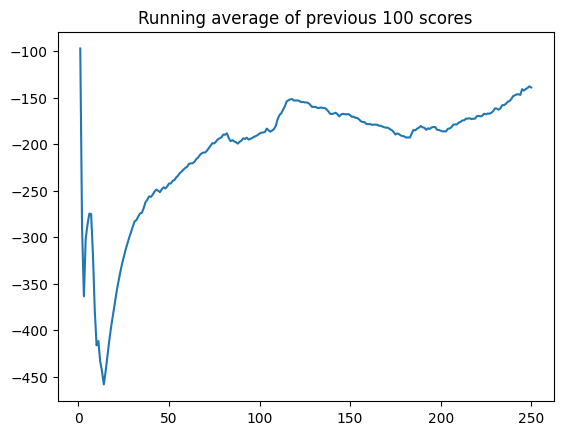

In [16]:
if __name__ == '__main__':
    env = gym.make('LunarLanderContinuous-v2')
    agent = Agent(alpha=0.0001, beta=0.001, 
                    input_dims=env.observation_space.shape, tau=0.001,
                    batch_size=64, fc1_dims=256, fc2_dims=128, 
                    n_actions=env.action_space.shape[0])
    n_games = 250
    filename = 'LunarLander_alpha_' + str(agent.alpha) + '_beta_' + \
                str(agent.beta) + '_' + str(n_games) + '_games'
    figure_file = 'plots/' + filename + '.png'

    best_score = env.reward_range[0]
    score_history = []
    for i in range(n_games):
        observation = env.reset()
        done = False
        score = 0
        agent.noise.reset()
        while not done:
            action = agent.choose_action(observation)
            observation_, reward, done, info = env.step(action)
            agent.remember(observation, action, reward, observation_, done)
            agent.learn()
            score += reward
            observation = observation_
        score_history.append(score)
        avg_score = np.mean(score_history[-100:])

        if avg_score > best_score:
            best_score = avg_score
            agent.save_models()

        print('episode ', i, 'score %.1f' % score,
                'average score %.1f' % avg_score)
    x = [i+1 for i in range(n_games)]
plot_learning_curve(x, score_history, figure_file)

... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
episode  0 score -120.5 average score -120.5
episode  1 score -568.7 average score -344.6
episode  2 score -114.0 average score -267.7
episode  3 score -441.0 average score -311.0
episode  4 score -464.7 average score -341.8
episode  5 score -636.9 average score -391.0
episode  6 score -392.9 average score -391.2
episode  7 score -942.1 average score -460.1
episode  8 score -801.3 average score -498.0
episode  9 score -347.3 average score -482.9
episode  10 score -326.5 average score -468.7
episode  11 score -436.4 average score -466.0
episode  12 score -523.5 average score -470.4
episode  13 score -403.9 average score -465.7
episode  14 score -421.9 average score -462.8
episode  15 score -561.5 average score -468.9
episode  16 score -889.0 average score -493.7
episode  17 score -863.4 average score -514.2
episode  18 score -675.9 average score -522.7
episode  19 score -469.6 average

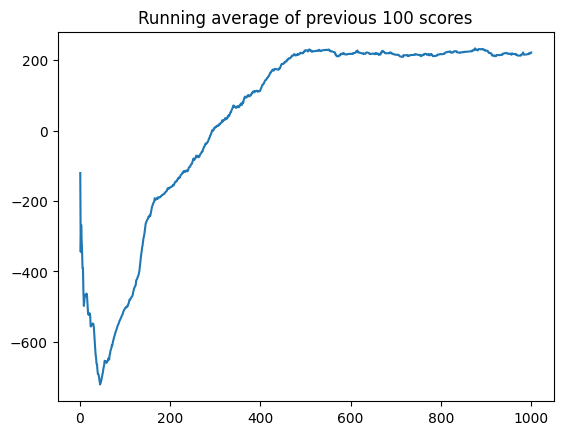

In [17]:
if __name__ == '__main__':
    env = gym.make('LunarLanderContinuous-v2')
    agent = Agent(alpha=0.0001, beta=0.001, 
                    input_dims=env.observation_space.shape, tau=0.001,
                    batch_size=64, fc1_dims=384, fc2_dims=256, 
                    n_actions=env.action_space.shape[0])
    n_games = 1000
    filename = 'LunarLander_alpha_' + str(agent.alpha) + '_beta_' + \
                str(agent.beta) + '_' + str(n_games) + '_games'
    figure_file = 'plots/' + filename + '.png'

    best_score = env.reward_range[0]
    score_history = []
    for i in range(n_games):
        observation = env.reset()
        done = False
        score = 0
        agent.noise.reset()
        while not done:
            action = agent.choose_action(observation)
            observation_, reward, done, info = env.step(action)
            agent.remember(observation, action, reward, observation_, done)
            agent.learn()
            score += reward
            observation = observation_
        score_history.append(score)
        avg_score = np.mean(score_history[-100:])

        if avg_score > best_score:
            best_score = avg_score
            agent.save_models()

        print('episode ', i, 'score %.1f' % score,
                'average score %.1f' % avg_score)
    x = [i+1 for i in range(n_games)]
plot_learning_curve(x, score_history, figure_file)

In [18]:
!zip -r ./a2c_lunar_lander_models.zip /content/tmp/a2c/

  adding: content/tmp/a2c/ (stored 0%)
  adding: content/tmp/a2c/target_critic_ddpg (deflated 3%)
  adding: content/tmp/a2c/critic_ddpg (deflated 18%)
  adding: content/tmp/a2c/actor_ddpg (deflated 8%)
  adding: content/tmp/a2c/target_actor_ddpg (deflated 8%)


<h2>Import and Test the trained models

In [19]:
def show_video_of_model(agent: Agent, env_name):
    env = gym.make(env_name)
    vid = video_recorder.VideoRecorder(env, path="videos/ll_cont/{}.mp4".format(env_name))
    state = env.reset()
    done = False
    while not done:
        frame = env.render(mode='rgb_array')
        vid.capture_frame()
        
        action = agent.choose_action(state)

        state, reward, done, _ = env.step(action)        
    env.close()

In [21]:
if __name__ == '__main__':
    env = gym.make('LunarLanderContinuous-v2')
    agent = Agent(alpha=0.0001, beta=0.001, 
                    input_dims=env.observation_space.shape, tau=0.001,
                    batch_size=64, fc1_dims=384, fc2_dims=256, 
                    n_actions=env.action_space.shape[0])
    agent.load_models()
    show_video_of_model(agent, 'LunarLanderContinuous-v2')

    

... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
